# Finding Degree of Profanity

## Assumptions:
1.we have a training data set named train.csv containing mixed types of tweets and marked with labels as 0's and 1's, indicating non-racial and racial tweets respectively.

2.we have a seprate testing data set named test.csv containing mixed types of tweets but not marked with 0's and 1's to test the model.


### Data preprocessing and cleaning 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
import re

In [2]:
training = pd.read_csv('train.csv')
testing = pd.read_csv('test.csv')
print('training=',training.shape,'\ntesting=',testing.shape)
training.head()

training= (31962, 3) 
testing= (17197, 2)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
testing.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [4]:
print(training.isnull().any())
print()
print(testing.isnull().any())

id       False
label    False
tweet    False
dtype: bool

id       False
tweet    False
dtype: bool


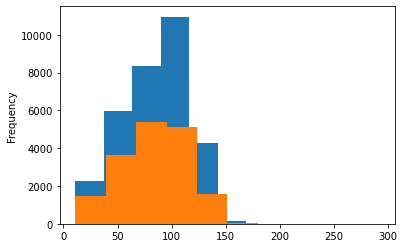

In [5]:
length_train = training['tweet'].str.len().plot.hist()
length_test = testing['tweet'].str.len().plot.hist()

### Stemming and Data visualizing 

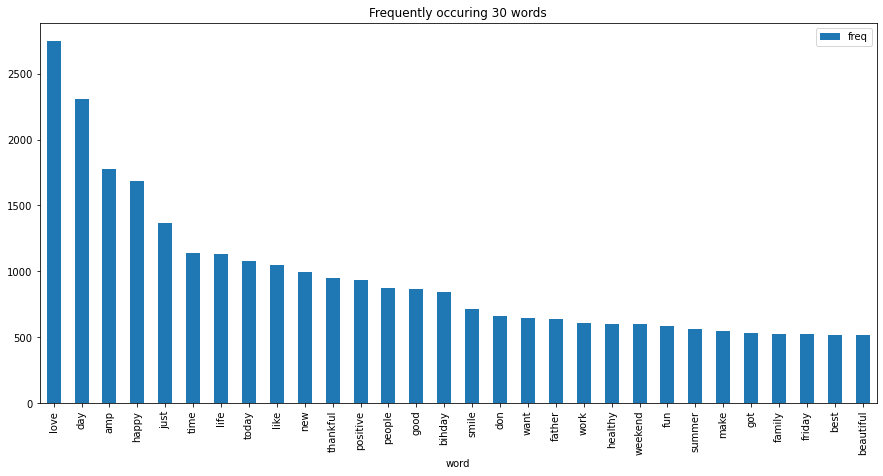

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(training.tweet)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.drop([0],inplace=True)
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7))
plt.title("Frequently occuring 30 words")
plt.xticks(rotation=90);

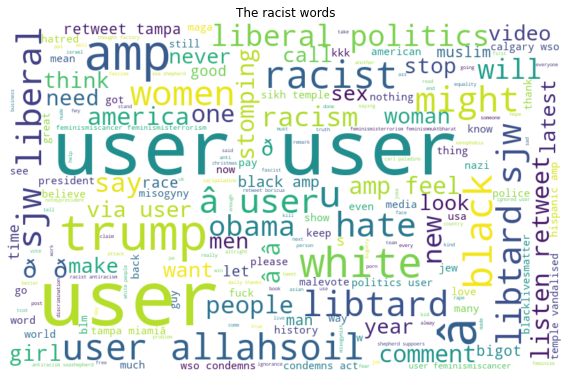

In [7]:
#Visualizing the Racist words
from wordcloud import WordCloud
negative_words =' '.join([text for text in training['tweet'][training['label'] == 1]])
wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The racist words');

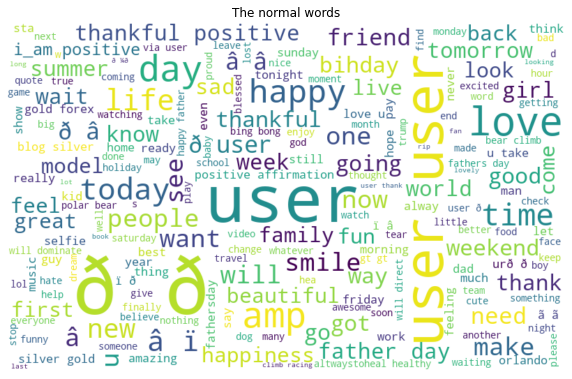

In [8]:
#Visualizing the Normal words
normal_words =' '.join([text for text in training['tweet'][training['label'] == 0]])
wordcloud = WordCloud(background_color='white',width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The normal words');

In [9]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [10]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(training['tweet'][training['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(training['tweet'][training['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

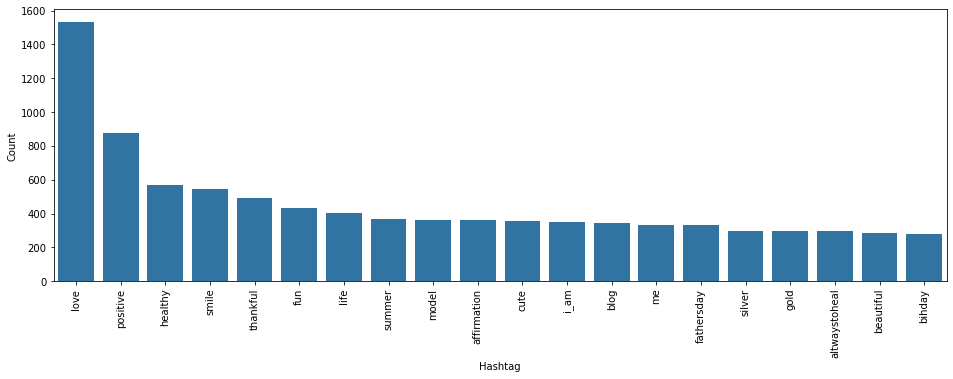

In [11]:
pallete=sns.color_palette()[0]
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",color=pallete)
ax.set(ylabel = 'Count')
plt.xticks(rotation=90);

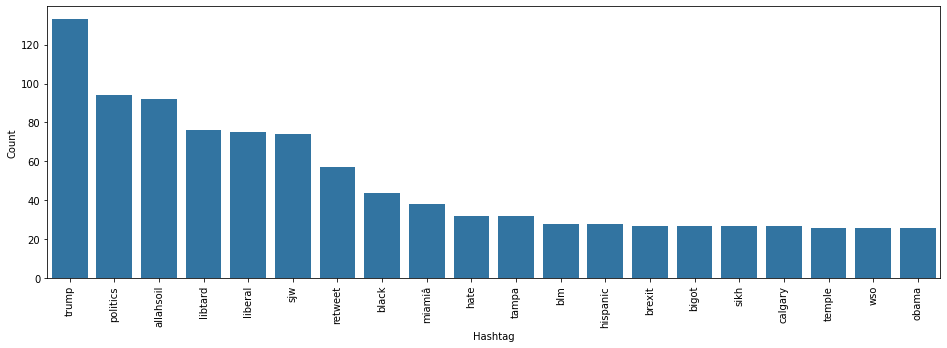

In [12]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",color=pallete)
ax.set(ylabel = 'Count')
plt.xticks(rotation=90);

### Tokenization and Training

In [13]:
# tokenizing the words present in the training set
tokenized_tweet = training['tweet'].apply(lambda x: x.split()) 

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(training['tweet']), epochs=20)

(6109761, 8411580)

##### Checking the trained model 

In [14]:
model_w2v.wv.most_similar(positive = "dinner")

[('spaghetti', 0.6972511410713196),
 ('#prosecco', 0.6644183993339539),
 ('coaching', 0.6402291059494019),
 ('later!', 0.631208062171936),
 ('bay.', 0.6310082674026489),
 ('october', 0.6275840401649475),
 ('#wanderlust', 0.6275381445884705),
 ('pampered', 0.6137372255325317),
 ('willow', 0.6136347651481628),
 ('dialogue', 0.6123429536819458)]

In [15]:
model_w2v.wv.most_similar(negative = "hate")

[('#apple', -0.049798235297203064),
 ('eyes', -0.06213691085577011),
 ('#hype', -0.07118978351354599),
 ('#fundraising', -0.07238244265317917),
 ('night.', -0.08382953703403473),
 ('#amwriting', -0.08418481796979904),
 ('#wednesdaywisdom', -0.08924324065446854),
 ('stas', -0.08969953656196594),
 ('#tech', -0.08996706455945969),
 ('time.', -0.09268860518932343)]

In [16]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

In [17]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)
labeled_tweets[:6]

[TaggedDocument(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 TaggedDocument(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 TaggedDocument(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 TaggedDocument(words=['#model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 TaggedDocument(words=['factsguide:', 'society', 'now', '#motivation'], tags=['tweet_4']),
 TaggedDocument(words=['[2/2]', 'huge', 'fan', 'fare', 'and', 'big', 'talking', 'before', 'they', 'leave.', 'chaos', 'and', 'pay', 'disputes', 'when', 'they', 'get', 'there.', '#allshowandnogo'],

In [18]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /home/harsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', training['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

In [20]:
test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', testing['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = training.iloc[:, 1]
x_test = cv.fit_transform(test_corpus).toarray()

print(x.shape)
print(y.shape)
print(x_test.shape)

(31962, 2500)
(31962,)
(17197, 2500)


In [22]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 2500)
(7991, 2500)
(23971,)
(7991,)


In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9531973470153923
F1 score : 0.6206896551724138
[[7311  121]
 [ 253  306]]


In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9851487213716574
Validation Accuracy : 0.9416843949443123
f1 score : 0.5933682373472949
[[7185  247]
 [ 219  340]]


/home/harsh/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9330496808910024
f1 score : 0.542343883661249
[[7139  293]
 [ 242  317]]


In [27]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


/home/harsh/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:56:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.9603687789412206
Validation Accuracy : 0.9555750218996371
f1 score : 0.5748502994011976
[[7396   36]
 [ 319  240]]
